In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


# hide warnings
import warnings
warnings.filterwarnings('ignore')

# update view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# read table for medication doses taken over 24 week period
m = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/raw_data_files/T_FRDOS.csv')

### All Data Cleaning Tasks

In [2]:
# drop columns whose data we are not using for this analysis

m = m.drop(columns=[col for col in m.columns if col not in ['patdeid','VISIT','DOS002','DOS005','DOS006']])

# rename columns according to documentation for interpretability

new_columns = {'DOS002':'medication','DOS005':'total_dose','DOS006':'admin_location'}

# renaming columns
m = m.rename(columns=new_columns)

# reorder columns for easier interpretation

m = m.reindex(columns=['patdeid','VISIT','medication','total_dose','admin_location'])


In [3]:

# update the VISIT column

# remove 'WK' from VISIT and convert to integer for ordinal value
m.VISIT = m.VISIT.str.replace('WK', '')

# replace 'BASELINE' with 0 for ordinal value
m.VISIT = m.VISIT.replace('BASELINE', 0)

# convert VISIT to int datatype
m.VISIT = m.VISIT.astype(np.int64)

m[:1] # check column names

,patdeid,VISIT,medication,total_dose,admin_location
0,1,0,2.0,8.0,1.0


In [4]:
# function to choose random patient id

def random_patient_id():
    return m.patdeid.sample().values[0]

# filter view to specific patient ID
# use groupby to index by VISIT to view all 24 visits and values for each visit

m.loc[m.patdeid==random_patient_id()].groupby('VISIT').agg('first')

,patdeid,medication,total_dose,admin_location
VISIT,,,,
0,110,1.0,40.0,1.0
1,110,1.0,50.0,1.0
2,110,1.0,60.0,1.0
3,110,1.0,60.0,1.0
4,110,1.0,75.0,1.0
5,110,1.0,75.0,1.0
6,110,1.0,75.0,1.0
7,110,1.0,75.0,1.0
8,110,1.0,75.0,2.0


### There were issues with data collection for medication dose, notice the 0.0 values.  We will forward fill those values to maintain accuracy

In [5]:
# convert 0.0 value in total_dose to NaN
m['total_dose'] = m['total_dose'].replace(0.0, np.nan)

# in total_dose column, front fill nan values
m['total_dose'] = m['total_dose'].fillna(method='ffill')

In [6]:
# back fill nan in medication column
m['medication'] = m['medication'].fillna(method='bfill')
m['admin_location'] = m['admin_location'].fillna(method='bfill')

In [7]:
m['total_visits'] = m.groupby('patdeid').VISIT.transform('nunique')

In [8]:
matv = m.loc[:,['patdeid','medication','admin_location','total_visits']].drop_duplicates(subset='patdeid',keep='first')

matv.to_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/feature_engineering_data/admin_visits.csv', index=False)

In [9]:
treatment_retention = m.groupby('patdeid').agg({'total_visits':'first'}).reset_index().total_visits.value_counts().sort_index(ascending=True)

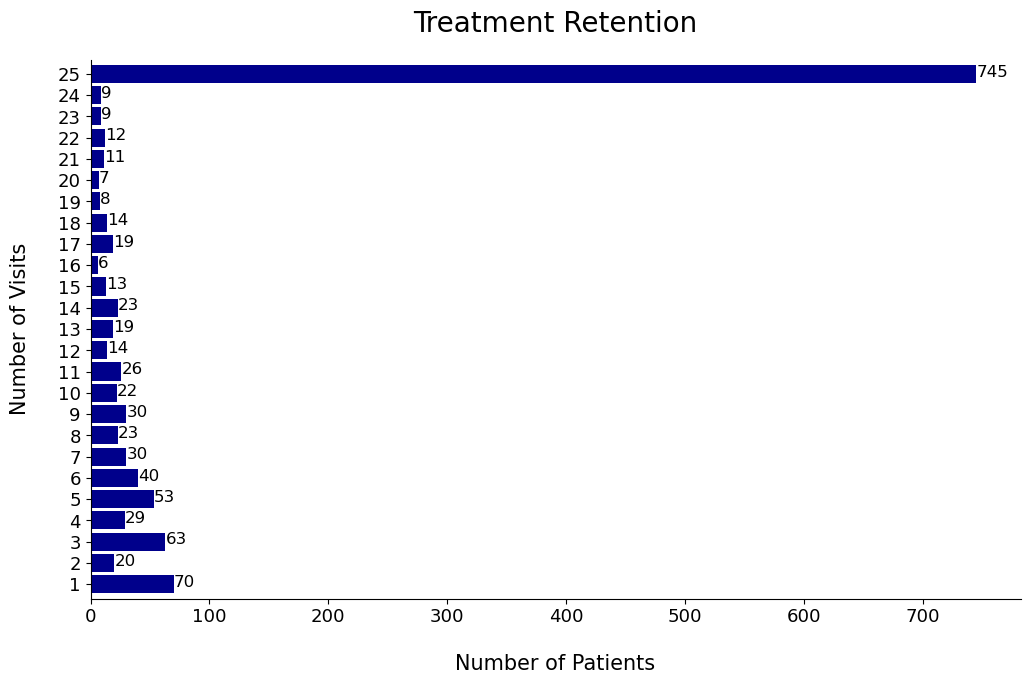

In [10]:
ax = treatment_retention.plot(kind='barh', figsize=(12,7), color='darkblue', fontsize=13, zorder=2, width=0.85)
# label bars with values
for i in ax.patches:
    ax.text(i.get_width()+.1, i.get_y()+.31, \
            str(round((i.get_width()), 2)), fontsize=12, color='black')
# remove grid lines
ax.grid(False, axis='y')
# remove border from plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# set title
ax.set_title('Treatment Retention', fontsize=20, pad=20)
# set x-axis label
ax.set_xlabel('Number of Patients', fontsize=15, labelpad=20)
# set y-axis label
ax.set_ylabel('Number of Visits', fontsize=15, labelpad=20);

In [11]:
treatment_retention.to_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/feature_engineering_data/m_treatment_retention.csv', index=False)

In [12]:
# aggregate dose per week
m = m.groupby(['patdeid','VISIT']).agg({'medication':'first','total_dose':'sum'})

m = m.reset_index()

m[:5]

,patdeid,VISIT,medication,total_dose
0,1,0,2.0,8.0
1,1,1,2.0,160.0
2,1,2,2.0,320.0
3,1,3,2.0,192.0
4,1,4,2.0,384.0


In [13]:
m['metha_dose_visit'] = m.loc[m.medication==1.0]['total_dose']
m['bupe_dose_visit'] = m.loc[m.medication==2.0]['total_dose']

m.metha_dose_visit.fillna(0, inplace=True)
m.bupe_dose_visit.fillna(0, inplace=True)

In [14]:
m[:5]

,patdeid,VISIT,medication,total_dose,metha_dose_visit,bupe_dose_visit
0,1,0,2.0,8.0,0.0,8.0
1,1,1,2.0,160.0,0.0,160.0
2,1,2,2.0,320.0,0.0,320.0
3,1,3,2.0,192.0,0.0,192.0
4,1,4,2.0,384.0,0.0,384.0


In [15]:
m = m.loc[m.VISIT!=0]

m = m.drop(columns=['total_dose','medication'])

In [16]:


# print shape and name of ea dataframe next to eachother
# for i in range(1,25):
   # print(globals()['VISIT%s' % i].shape, 'VISIT%s' % i)

In [17]:
def flatten_dataframe(df):
    # create a new dataframe for every filter of visit column
    # the name of the dataframe with be VISIT+number of visit
    for i in df['VISIT'].unique():
        globals()['VISIT%s' % i] = df[df['VISIT']==i]

    # for each dataframe beteween VISIT1 and VISIT24
    # add the value in VISIT to the end of the name of each column +"_"+"visit"
    # skip the first 5 columns (patdeid, VISIT, medication, admin_location, total_visits)
    for i in range(1,25):
        for col in globals()['VISIT%s' % i].columns[1:]:
            globals()['VISIT%s' % i][col+'_'+str(i)] = globals()['VISIT%s' % i][col]
            globals()['VISIT%s' % i] = globals()['VISIT%s' % i].drop(columns=col)

    # merge all dfs using left merge on patdeid
    for i in range(1,25):
        if i == 1:
            result = pd.merge(globals()['VISIT%s' % i], globals()['VISIT%s' % (i+1)], on='patdeid', how='left')
        elif i < 24:
            result = pd.merge(result, globals()['VISIT%s' % (i+1)], on='patdeid', how='left')
        else:
            result = result

    # drop erroneous visit columns, as the visit is encoded in each column
    result = result.drop(columns=[col for col in result.columns if col.startswith('VISIT')], axis=1)

    return result

# Example usage:
processed_df = process_medication_data(df)
processed_df[:5]


,patdeid,metha_dose_visit_1,bupe_dose_visit_1,metha_dose_visit_2,bupe_dose_visit_2,metha_dose_visit_3,bupe_dose_visit_3,metha_dose_visit_4,bupe_dose_visit_4,metha_dose_visit_5,bupe_dose_visit_5,metha_dose_visit_6,bupe_dose_visit_6,metha_dose_visit_7,bupe_dose_visit_7,metha_dose_visit_8,bupe_dose_visit_8,metha_dose_visit_9,bupe_dose_visit_9,metha_dose_visit_10,bupe_dose_visit_10,metha_dose_visit_11,bupe_dose_visit_11,metha_dose_visit_12,bupe_dose_visit_12,metha_dose_visit_13,bupe_dose_visit_13,metha_dose_visit_14,bupe_dose_visit_14,metha_dose_visit_15,bupe_dose_visit_15,metha_dose_visit_16,bupe_dose_visit_16,metha_dose_visit_17,bupe_dose_visit_17,metha_dose_visit_18,bupe_dose_visit_18,metha_dose_visit_19,bupe_dose_visit_19,metha_dose_visit_20,bupe_dose_visit_20,metha_dose_visit_21,bupe_dose_visit_21,metha_dose_visit_22,bupe_dose_visit_22,metha_dose_visit_23,bupe_dose_visit_23,metha_dose_visit_24,bupe_dose_visit_24
0,1,0.0,160.0,0.0,320.0,0.0,192.0,0.0,384.0,0.0,96.0,0.0,96.0,0.0,352.0,0.0,128.0,0.0,256.0,0.0,256.0,0.0,224.0,0.0,448.0,0.0,32.0,0.0,224.0,0.0,224.0,0.0,240.0,0.0,182.0,0.0,182.0,0.0,240.0,0.0,210.0,0.0,180.0,0.0,246.0,0.0,128.0,0.0,188.0
1,2,0.0,64.0,0.0,68.0,0.0,84.0,0.0,60.0,0.0,108.0,0.0,84.0,0.0,96.0,0.0,36.0,0.0,96.0,0.0,88.0,0.0,112.0,0.0,104.0,0.0,56.0,0.0,88.0,0.0,160.0,0.0,80.0,0.0,72.0,0.0,56.0,0.0,56.0,0.0,56.0,0.0,80.0,0.0,84.0,0.0,84.0,0.0,68.0
2,3,170.0,0.0,350.0,0.0,420.0,0.0,420.0,0.0,540.0,0.0,310.0,0.0,455.0,0.0,455.0,0.0,480.0,0.0,600.0,0.0,455.0,0.0,560.0,0.0,800.0,0.0,600.0,0.0,360.0,0.0,640.0,0.0,700.0,0.0,700.0,0.0,800.0,0.0,600.0,0.0,765.0,0.0,630.0,0.0,510.0,0.0,715.0,0.0
3,4,0.0,248.0,0.0,256.0,0.0,160.0,0.0,96.0,0.0,416.0,0.0,256.0,0.0,224.0,0.0,224.0,0.0,224.0,0.0,224.0,0.0,224.0,0.0,320.0,0.0,160.0,0.0,256.0,0.0,160.0,0.0,320.0,0.0,128.0,0.0,256.0,0.0,192.0,0.0,448.0,0.0,64.0,0.0,160.0,0.0,192.0,0.0,96.0
4,6,0.0,16.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.shape

(1239, 49)

In [19]:
df.to_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/feature_engineering_data/medication.csv', index=False)